<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/templates/PSD_analysis_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/templates/PSD_analysis_starter.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# PSD Analysis

The analysis notebook contains starter code for doing PSD analysis.




## Libraries

In [1]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth

# Data analysis
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Authentication

We need to authenticate in order to bring in the database credentials from Google drive so that we can pull data from the live database.

In [2]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials.py", "psql_credentials.py")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'psql_credentials.py'

In [3]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

## Compiling PSD data from radiation events

We collect the time, energy and psp value of each radiation event and store it in a SQL database. In order to create a PSD plot and perform analysis, we need to work with 2D histogram. In other words, we need to count the number of events in given energy/psp buckets.

The database is optimised for performing these kind of aggregations over large volumes of data so we lean on its capabilities instead of attempting to bring all the data into python and then aggregating.


In [4]:
def get_psd_data(start_time, end_time, digitizer, channel_number):
  query = f"""
  SELECT
      width_bucket(channels[1], 0, 1, 128) AS psp_bin,
      width_bucket(channels[2], 0, 4000, 512) AS energy_bin,
      COUNT(*) AS count
  FROM {digitizer}_ch{channel_number}
  WHERE time BETWEEN '{start_time}' AND '{end_time}'
  GROUP BY psp_bin, energy_bin
  ORDER BY psp_bin, energy_bin;
  """
  return pd.read_sql(query, engine, index_col=None)

Let's pull out some data collected using the `caen8ch` digitzer on channel `0` from `2024-12-25 15:00` to `2025-01-12 12:00`.

In [5]:
start_time = "2024-12-25 15:00"
end_time = "2025-01-12 12:00"
digitizer = "caen8ch"
channel_number = 0

In [6]:
df_psd = get_psd_data(start_time, end_time, digitizer, channel_number)

In [7]:
df_psd.head()

,psp_bin,energy_bin,count
0,1,513,22330
1,2,513,2086
2,3,513,2303
3,4,5,3
4,4,513,2382


## Visualising the PSD plots


In [8]:
def plot_psd(data, period=None, title="PSD", psp_threshold=None, ax=None):
    # Initialise histogram
    hist = np.zeros((512, 128), dtype=int)

    # Accumulate counts
    for row in data.itertuples(index=False):
        psp_bin, energy_bin, count = row
        if 0 <= energy_bin < 512 and 0 <= psp_bin < 128:
            hist[energy_bin, psp_bin] += int(count)

    # Define bin edges
    energy_edges = np.linspace(0, 4000, 513)  # 512 bins → 513 edges
    psp_edges = np.linspace(0, 1, 129)        # 128 bins → 129 edges

    # Plot with pcolormesh and log colour scale
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

    im = ax.pcolormesh(energy_edges, psp_edges, hist.T,
                      norm=mcolors.LogNorm(vmin=1, vmax=hist.max()),
                      cmap='viridis', shading='auto')
    ax.set_xlabel('Energy')
    ax.set_ylabel('PSP')
    ax.set_title(title)

    # Draw horizontal red line at psp_threshold if provided
    if psp_threshold is not None:
        if 0 <= psp_threshold <= 1:  # Ensure threshold is within PSP range [0, 1]
            ax.axhline(y=psp_threshold, color='red', linestyle='-', label=f'PSP Threshold: {psp_threshold:.3f}')
            ax.legend()

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Count (log scale)')

    if ax is None:
        plt.show()

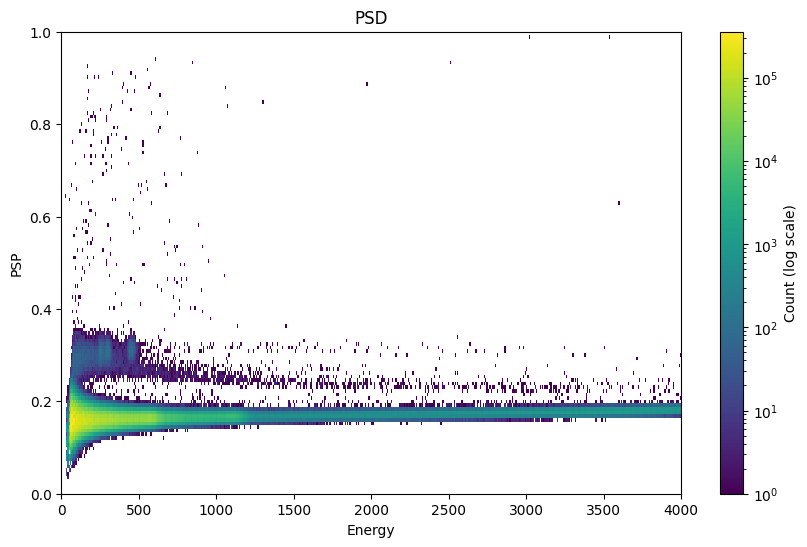

In [9]:
plot_psd(df_psd)

## Calculating the PSP threshold

The most accurate way to discriminate between gammas and neutrons is to create a fiducial lines. For the purpose of eyeballing neutron/gamma counts during a live experiment, a simple threshold psp value can be a good enough.

Below is the Guassaian drop method which:
- Fits the signals with Guassians
- Finds the psp value at which the gammas drop to some fraction of their peak, e.g. 0.1%

In [10]:
# --- Gaussian definitions ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) +
            gaussian(x, amp2, mu2, sigma2))

def find_psp_threshold_gaussian(data, target_energy=500,
                                     energy_range=(0, 4000), psp_range=(0, 1),
                                     energy_bins=512, psp_bins=128,
                                     plot=True, mean_tol=0.02, amp_ratio_tol=0.1,
                                     drop_fraction=0.001):
    """
    Fits Gaussian(s) to PSP distribution at a given energy and finds PSP threshold
    where the lower Gaussian drops to 0.1% of its peak.
    Falls back to single Gaussian if fitted Gaussians are too similar.
    """

    # Step 1: Map energy to closest bin
    bin_width_e = (energy_range[1] - energy_range[0]) / energy_bins
    closest_energy_bin = int(round(target_energy / bin_width_e))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))

    # Step 2: Filter data for that energy bin
    filtered = data[data['energy_bin'] == closest_energy_bin]
    if filtered.empty:
        raise ValueError(f"No data for bin {closest_energy_bin} (~{target_energy})")

    # Step 3: Build histogram
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins
    hist = np.zeros(psp_bins)
    for _, row in filtered.iterrows():
        idx = row['psp_bin'] - 1
        if 0 <= idx < psp_bins:
            hist[idx] += row['count']

    psp_centres = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2

    # Step 4: Try to detect peaks
    peaks, _ = find_peaks(hist, height=np.max(hist) * 0.05)
    use_double = len(peaks) >= 2

    if use_double:
        # Initial guess: amplitudes, means, sigmas
        p0 = [hist[peaks[0]], psp_centres[peaks[0]], 0.01,
              hist[peaks[1]], psp_centres[peaks[1]], 0.01]
        bounds = (0, [np.inf, 1, np.inf, np.inf, 1, np.inf])
        popt, _ = curve_fit(double_gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [(popt[0], popt[1], popt[2]), (popt[3], popt[4], popt[5])]

        # Check if we should fall back to single Gaussian
        mu_diff = abs(params[0][1] - params[1][1])
        amp_ratio = min(params[0][0], params[1][0]) / max(params[0][0], params[1][0])
        if mu_diff < mean_tol or amp_ratio < amp_ratio_tol:
            use_double = False

    if not use_double:
        # Fit single Gaussian
        p0 = [np.max(hist), psp_centres[np.argmax(hist)], 0.01]
        bounds = (0, [np.inf, 1, np.inf])
        popt, _ = curve_fit(gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [tuple(popt)]

    # Step 5: Select lower Gaussian (smallest mean)
    lower_gauss = min(params, key=lambda p: p[1])
    amp, mu, sigma = lower_gauss

    # Step 6: Compute PSP threshold at 0.1% of peak
    delta = np.sqrt(-2 * sigma**2 * np.log(drop_fraction))
    psp_threshold = mu + delta  # right-side cutoff

    # Step 7: Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(psp_centres, hist, width=psp_bin_width, alpha=0.6, label="Data")
        if use_double:
            plt.plot(psp_centres, double_gaussian(psp_centres, *popt), 'k-', label="Double Gaussian fit")
            for amp_i, mu_i, sigma_i in params:
                plt.plot(psp_centres, gaussian(psp_centres, amp_i, mu_i, sigma_i), '--', label=f"Gaussian μ={mu_i:.3f}")
        else:
            plt.plot(psp_centres, gaussian(psp_centres, *params[0]), 'k-', label="Single Gaussian fit")
        plt.axvline(psp_threshold, color='r', linestyle='--', label=f"Threshold={psp_threshold:.3f}")
        plt.xlabel('PSP')
        plt.ylabel('Count')
        plt.title(f'PSP Gaussian Fit at Energy ~{target_energy}')
        plt.legend()
        plt.show()

    return psp_threshold


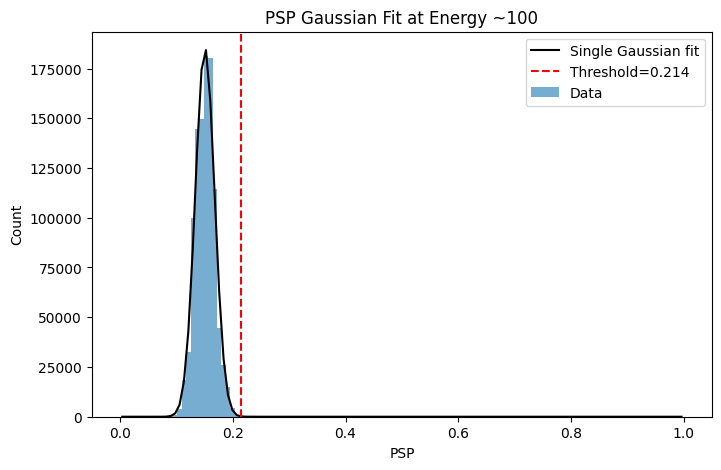

In [11]:
psp_threshold = find_psp_threshold_gaussian(df_psd, target_energy=100, drop_fraction=0.001)

We can now plot this threshold back onto the PSD plot.

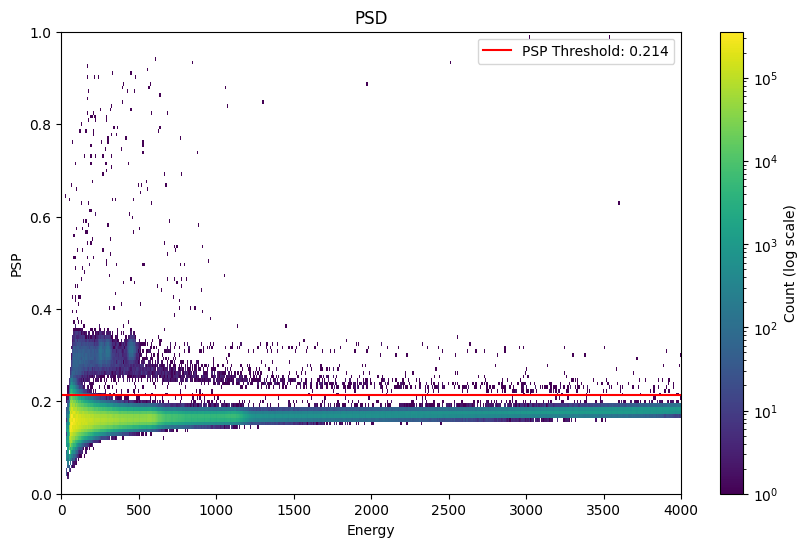

In [12]:
plot_psd(df_psd, psp_threshold=psp_threshold)

## PSP thresold over time

To detect any detector drift we can perform the same analaysis as above but spit the data into several parts to get psp threshold over time.

In [13]:
def psp_threshold_over_time(start_time, end_time, n_segments, digitizer, channel_number,
                            target_energy=100, drop_fraction=0.001,
                            show_psd_plots=True):
    """
    Calculate PSP thresholds over time between two given datetimes,
    by splitting into n_segments and re-querying PSD data for each.

    Parameters
    ----------
    start_time : str
        Start time in format "YYYY-MM-DD HH:MM".
    end_time : str
        End time in format "YYYY-MM-DD HH:MM".
    digitizer : str
        Digitizer name for SQL table.
    channel_number : int
        Digitizer channel number.
    n_segments : int
        Number of time segments to divide the range into.
    target_energy : float
        Energy to use for PSP threshold calculation (default 100 for Gaussian method).
    drop_fraction : float
        Fraction of gamma peak height to define the PSP threshold.
    show_psd_plots : bool
        Whether to show PSD plots for each segment.

    Returns
    -------
    thresholds : list of float
        PSP thresholds for each segment.
    """
    # Convert to pandas Timestamps
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    if start_time >= end_time:
        raise ValueError("start_time must be earlier than end_time")

    total_duration = (end_time - start_time) / n_segments
    thresholds = []
    mid_times = []

    for i in range(n_segments):
        seg_start = start_time + i * total_duration
        seg_end = seg_start + total_duration
        seg_mid = seg_start + total_duration / 2
        mid_times.append(seg_mid)

        seg_data = get_psd_data(seg_start, seg_end, digitizer, channel_number)

        if seg_data.empty:
            thresholds.append(np.nan)
            print(f"Segment {i+1} ({seg_start} - {seg_end}): No data")
            continue

        try:
            th = find_psp_threshold_gaussian(
                seg_data,
                target_energy=target_energy,
                drop_fraction=drop_fraction,
                plot=False
            )
            thresholds.append(th)
            print(f"Segment {i+1} ({seg_start} - {seg_end}): PSP threshold = {th:.4f}")

            if show_psd_plots:
                plt.figure(figsize=(8, 6))
                plot_psd(seg_data, period=None,
                         title=f"Segment {i+1} ({seg_start} - {seg_end})",
                         psp_threshold=th)
                plt.show()

        except ValueError as e:
            thresholds.append(np.nan)
            print(f"Segment {i+1} ({seg_start} - {seg_end}): {e}")

    # Final trend plot using midpoint times
    plt.figure(figsize=(10, 5))
    plt.plot(mid_times, thresholds, marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("PSP Threshold (Gaussian drop method)")
    plt.title(f"PSP Threshold Over Time")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return thresholds


Let's break apart the data into 10 segement and see how stable the psp threshold is.

In [14]:
n_segments = 10

Segment 1 (2024-12-25 15:00:00 - 2024-12-27 09:54:00): PSP threshold = 0.2144
Segment 2 (2024-12-27 09:54:00 - 2024-12-29 04:48:00): PSP threshold = 0.2144
Segment 3 (2024-12-29 04:48:00 - 2024-12-30 23:42:00): PSP threshold = 0.2147
Segment 4 (2024-12-30 23:42:00 - 2025-01-01 18:36:00): PSP threshold = 0.2147
Segment 5 (2025-01-01 18:36:00 - 2025-01-03 13:30:00): PSP threshold = 0.2144
Segment 6 (2025-01-03 13:30:00 - 2025-01-05 08:24:00): PSP threshold = 0.2145
Segment 7 (2025-01-05 08:24:00 - 2025-01-07 03:18:00): PSP threshold = 0.2141
Segment 8 (2025-01-07 03:18:00 - 2025-01-08 22:12:00): PSP threshold = 0.2143
Segment 9 (2025-01-08 22:12:00 - 2025-01-10 17:06:00): PSP threshold = 0.2141
Segment 10 (2025-01-10 17:06:00 - 2025-01-12 12:00:00): PSP threshold = 0.2146


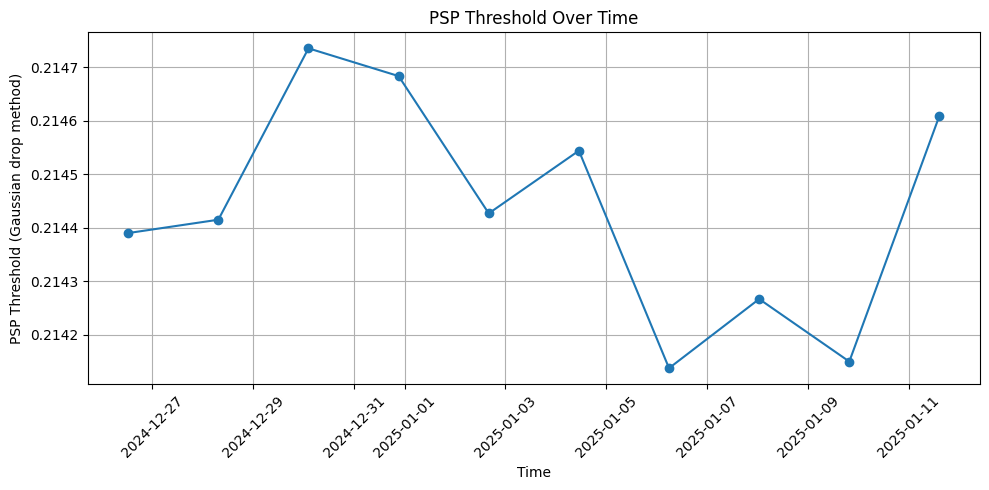

In [15]:
thresholds = psp_threshold_over_time(start_time, end_time, n_segments, digitizer, channel_number, show_psd_plots=False)
